#### Toxicity prediction with DeepChem fully-connected neural networks and LIME for model explainability

In [1]:
import deepchem as dc
import numpy as np
import pandas as pd

2023-06-20 21:47:18.960690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 21:47:19.862943: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/lac/anaconda3/envs/deepchem_env/lib/
2023-06-20 21:47:19.863138: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/lac/anaconda3/envs/deepchem_env/lib/
2023-06-20 21:47:19.863150: W tensorflow/c

In [2]:
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='ECFP')
train_dataset, valid_dataset, test_dataset = datasets

In [3]:
print(train_dataset)
print(valid_dataset)
print(test_dataset)
print(tasks)
print(transformers)

<DiskDataset X.shape: (6264, 1024), y.shape: (6264, 12), w.shape: (6264, 12), task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>
<DiskDataset X.shape: (783, 1024), y.shape: (783, 12), w.shape: (783, 12), ids: ['N#C[C@@H]1CC(F)(F)CN1C(=O)CNC1CC2CCC(C1)N2c1ncccn1'
 'CN(C)C(=O)NC1(c2ccccc2)CCN(CCC[C@@]2(c3ccc(Cl)c(Cl)c3)CCCN(C(=O)c3ccccc3)C2)CC1'
 'CSc1nnc(C(C)(C)C)c(=O)n1N' ...
 'O=C(O[C@H]1CN2CCC1CC2)N1CCc2ccccc2[C@@H]1c1ccccc1'
 'C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4[C@H]3C(=C)C[C@@]21CC'
 'NC(=O)C(c1ccccc1)(c1ccccc1)[C@@H]1CCN(CCc2ccc3c(c2)CCO3)C1'], task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>
<DiskDataset X.shape: (784, 1024), y.shape: (784, 12), w.shape: (784, 12), ids: ['CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@H]1C(=O)O.CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@H]1C(=O)O.c1ccc(CNCCNCc2ccccc2)cc1'
 'CC(C)(c1ccc(Oc2ccc3c(c2)C(=O)OC3=O)cc1)c1ccc(Oc2ccc3c(c2)C(=O)OC3=O)cc1'
 'Cc1cc(C(C)(C)C)c(O)c(C)c1Cn1c(=O)n(Cc

In [4]:
n_tasks = len(tasks)

model = dc.models.RobustMultitaskClassifier(n_tasks=12, 
                                            n_features=1024, 
                                            layer_sizes=[1024],
                                            model_dir='../models')

2023-06-20 21:47:20.851919: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/lac/anaconda3/envs/deepchem_env/lib/
2023-06-20 21:47:20.851943: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-20 21:47:20.851989: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: lac-rog
2023-06-20 21:47:20.851998: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: lac-rog
2023-06-20 21:47:20.852121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-06-20 21:47:20.852161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.c

In [5]:
model.fit(train_dataset, nb_epoch=10)

0.4563174247741699

In [6]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification")
print('Training set score:', model.evaluate(train_dataset, [metric], transformers))
print('Validation set score:', model.evaluate(valid_dataset, [metric], transformers))
print('Test set score:', model.evaluate(test_dataset, [metric], transformers))

Training set score: {'mean-roc_auc_score': 0.9656481682288404}
Validation set score: {'mean-roc_auc_score': 0.6975705971759535}
Test set score: {'mean-roc_auc_score': 0.671718891778684}


In [7]:
pred = model.predict(test_dataset)

In [8]:
# [nontoxic, toxic] for each class
pred

array([[[3.86240333e-01, 6.13759756e-01],
        [9.42484021e-01, 5.75159416e-02],
        [9.76585686e-01, 2.34143510e-02],
        ...,
        [9.31531429e-01, 6.84685484e-02],
        [9.54682589e-01, 4.53173369e-02],
        [9.74174976e-01, 2.58249901e-02]],

       [[9.88325059e-01, 1.16749601e-02],
        [9.99941885e-01, 5.80435371e-05],
        [6.79385662e-01, 3.20614189e-01],
        ...,
        [9.98585939e-01, 1.41409878e-03],
        [3.29913758e-02, 9.67008591e-01],
        [9.84478056e-01, 1.55218374e-02]],

       [[9.99241829e-01, 7.58154376e-04],
        [9.99915540e-01, 8.43410016e-05],
        [9.86849129e-01, 1.31507618e-02],
        ...,
        [3.04742515e-01, 6.95257545e-01],
        [5.61233878e-01, 4.38766032e-01],
        [8.25985730e-01, 1.74014270e-01]],

       ...,

       [[9.86584842e-01, 1.34151978e-02],
        [9.88634586e-01, 1.13653895e-02],
        [9.85089004e-01, 1.49108721e-02],
        ...,
        [9.86802757e-01, 1.31970746e-02],
     

In [9]:
pred.shape

(784, 12, 2)

In [10]:
y_true = test_dataset.y
print(y_true[0:10])
print(pred[3])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[9.8402560e-01 1.5974414e-02]
 [9.9910963e-01 8.9027459e-04]
 [9.8349679e-01 1.6503191e-02]
 [9.9941647e-01 5.8359106e-04]
 [7.6336759e-01 2.3663250e-01]
 [9.5277148e-01 4.7228534e-02]
 [9.9998385e-01 1.6118662e-05]
 [9.8841810e-01 1.1581871e-02]
 [9.9685669e-01 3.1432798e-03]
 [9.9277127e-01 7.2287042e-03]
 [9.9752784e-01 2.4721078e-03]
 [9.9996108e-01 3.8842292e-05]]


In [11]:
metric = dc.metrics.roc_auc_score
cummulative_score = 0.
for i in range(n_tasks):
    score = metric(dc.metrics.to_one_hot(y_true[:,i]), pred[:,i])
    print(tasks[i], score)
    cummulative_score += score

NR-AR 0.6950927149077745
NR-AR-LBD 0.7263329893360853
NR-AhR 0.7378110077909021
NR-Aromatase 0.6538222812436849
NR-ER 0.6366846738695477
NR-ER-LBD 0.7150346377082943
NR-PPAR-gamma 0.5647220233834407
SR-ARE 0.5891166590319132
SR-ATAD5 0.7342936690473308
SR-HSE 0.6541470596726233
SR-MMP 0.6726623062015504
SR-p53 0.6809066791510612


In [12]:
avg_score = cummulative_score/n_tasks
avg_score

0.671718891778684

In [13]:
! pip install lime

In [14]:
from lime import lime_tabular

# create feature names for the circular fingerprints
feature_names = ["fp_%s" % x for x in range(1024)]

# create Explainer object for lime
explainer = lime_tabular.LimeTabularExplainer(train_dataset.X,
                                              feature_names=feature_names,
                                              categorical_features=feature_names,
                                              class_names=['nontoxic', 'toxic'],
                                              discretize_continuous=True,
                                              mode='classification',
                                              verbose=True)

#### Explain why the model predicts a molecule to be toxic for NR-AR-LBD 

In [15]:
# create evaluation function for the model
# input: 2D numpy array (observations, features)
# output: predictions (observations, )

def eval_model(nn_model):
    def eval_closure(x):
        dataset = dc.data.NumpyDataset(x, n_tasks=12)
        # the 1st task is NR-AR-LBD (Toxic = Binding to Androgen Receptor Ligand Binding Domain)
        predictions = nn_model.predict(dataset)[:,1]
        return predictions
    return eval_closure

In [16]:
eval_model_fn = eval_model(model)

In [17]:
# apply evaluation function on toxic molecule(s) in test_dataset

toxic_cmpds = np.where(test_dataset.y[:,1] == 1)
toxic_cmpds

(array([ 19,  82, 103, 125, 151, 180, 248, 276, 317, 325, 336, 393, 443,
        465, 468, 568, 623, 663, 759]),)

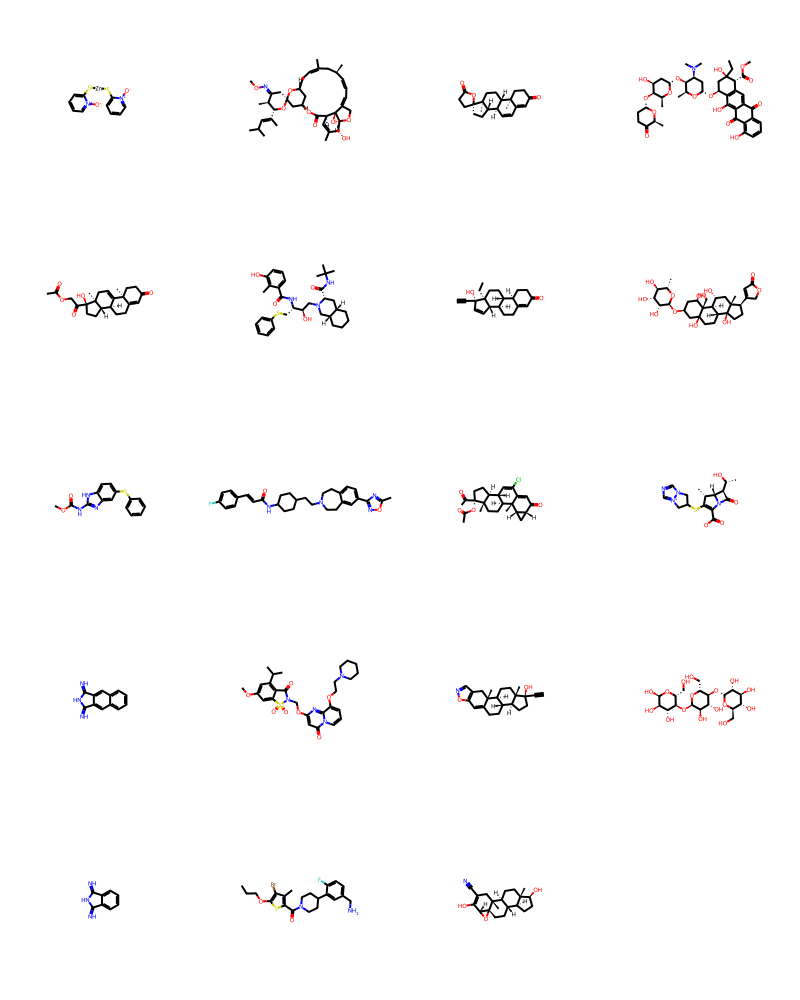

In [19]:
from rdkit import Chem
from rdkit.Chem import Draw

mols = [Chem.MolFromSmiles(smi) for smi in test_dataset.ids[toxic_cmpds]]

Draw.MolsToGridImage(mols=mols, molsPerRow=4)

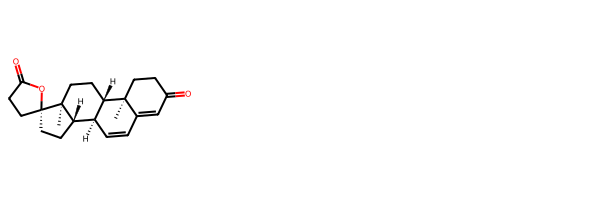

In [20]:
tox_id = toxic_cmpds[0][2]
Draw.MolsToGridImage(mols=[Chem.MolFromSmiles(test_dataset.ids[tox_id])])

In [21]:
test_dataset.ids[tox_id]

'C[C@]12CC[C@H]3[C@@H](C=CC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@@]21CCC(=O)O1'

In [22]:
expl = explainer.explain_instance(test_dataset.X[tox_id], eval_model_fn, num_features=5)

expl.show_in_notebook(show_table=True)

Intercept 0.30663155633105266
Prediction_local [0.40027831]
Right: 0.6516427


In [23]:
def fp_mol(mol, fp_length=1024):

    """
    returns: dict of <int:list of string>
        dictionary mapping fingerprint index
        to list of smile string that activated that fingerprint
    """
    d = {}
    feat = dc.feat.CircularFingerprint(sparse=True, smiles=True, size=fp_length)
    retval = feat._featurize(mol)
             
    for k, v in retval.items():
        index = k % fp_length
        if index not in d:
            d[index] = set()
        d[index].add(v['smiles'])
    return d

In [24]:
fg_fp = fp_mol(Chem.MolFromSmiles(test_dataset.ids[tox_id]))

In [25]:
fg_fp

{314: {'C=O'},
 555: {'C[C@](C)(C)CCC'},
 177: {'CCC(CC)(OC)C(C)(C)C'},
 479: {'CCCC(C)=O'},
 1006: {'C[C@](C)(O)CCC'},
 412: {'CC(C)(C)C'},
 245: {'C[C@@](C)(O)CCC'},
 650: {''},
 970: {'CC(=O)O'},
 547: {'C=CC'},
 84: {'C=CC'},
 860: {'CC(C)(C)C', 'CC[C@@](C)([C@H](C)C)C(C)(C)O'},
 714: {'CCC'},
 519: {'C[C@H](C)C'},
 666: {'CC(C)(C)[C@@H](CC)[C@@H](C)C', 'CC(C)=CC(C)=O'},
 88: {'CCCC(C)(C)C'},
 1015: {'CCCC(=O)O'},
 841: {'C=CC(=O)CC'},
 250: {'CC'},
 274: {'C[C@@H](C)C(C=C)[C@@H](C)C'},
 301: {'CCC'},
 138: {'CCC'},
 604: {'CC(=C)C'},
 33: {''},
 32: {'CC(C)C'},
 59: {'C=CC'},
 420: {'C=CC(=CC)C(C)(C)C'},
 917: {'CC(C)(C)O'},
 821: {'CC(C)(C)OC(C)=O'},
 529: {'CCC[C@H](C)C'},
 258: {'COC'},
 926: {''},
 1019: {''},
 36: {''},
 985: {'COC(=O)CC'},
 656: {''},
 735: {'CC(=C)C=CC'},
 356: {''},
 849: {''},
 65: {'CC=CC(C)C'},
 242: {'CC(C)=O'},
 132: {'C=C(C)[C@](C)(CC)[C@@H](C)C'},
 574: {'CC[C@@H]([C@@H](C)C)C(C)(C)C'}}

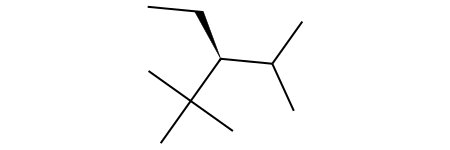

In [26]:
Chem.MolFromSmiles(list(fg_fp[574])[0])

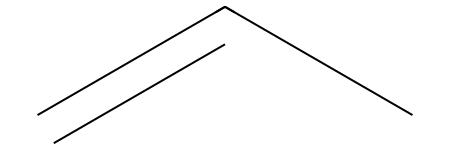

In [27]:
Chem.MolFromSmiles(list(fg_fp[84])[0])

In [28]:
# calculate which fragments activate all fingerprint
# indexes throughout the entire training set
all_train_fps = {}
X = train_dataset.X
ids = train_dataset.ids
for i in range(len(X)):
    d = fp_mol(Chem.MolFromSmiles(ids[i]))
    for k, v in d.items():
        if k not in all_train_fps:
            all_train_fps[k] = set()
        all_train_fps[k].update(v)

[21:51:32] WARNING: not removing hydrogen atom without neighbors


In [29]:
all_train_fps

{874: {'CC(=O)CN',
  'CC(C)CO',
  'CC(F)(F)S(=O)(=O)[O-]',
  'CC(N)=O',
  'CCC(C)O',
  'CCCN(C)C',
  'CCC[Si](O)(O)O',
  'CCNC(=N)N',
  'CCOC(N)=O',
  'CC[C@@H]([C@@H](C)N)C(C)(C)O',
  'CN(c)CC(N)=O',
  'COC',
  'COP(=O)(O)OC',
  'CP(=O)(O)O',
  'C[C@@H](N)C[C@](C)(C)O',
  'O=C(O)O',
  'cC(C)(C)O',
  'cCC(C)N',
  'cC[C@@H](C)N',
  'cC[C@H](C)N',
  'c[nH]c(=O)n(c)C',
  'cc(Cl)c(c(c)Cl)N(C)C',
  'cc(c)CCC',
  'ccc(OC)c(c)C',
  'ccnc(c)Cl'},
 149: {'C#Cc(c)c',
  'C=CC[C@H](C)O',
  'CC(=O)CC(C)C',
  'CC(C)(C)O',
  'CC(C)(N)O',
  'CC(O)(P)P(=O)(O)O',
  'CCC(C)OC',
  'CCCC#N',
  'CCCC(C)Br',
  'CCN(C)[C@H](C)C',
  'CN(C)SN(C)C',
  'CN(S)C(=O)ON',
  'CNC(=O)C(C)C',
  'Cc([nH])c(Br)c(n)=O',
  'c[C@@H](N)CC(N)=O',
  'cc(Cl)c(c(c)Cl)[N+](=O)[O-]',
  'cc(n)n(cn)CC',
  'ccc(Oc)c(c)Br',
  'cn(C)c(C)[n+](c)C'},
 807: {'',
  'C=C(C)C',
  'C=C(C)c(cc)c(c)C',
  'C=CCBr',
  'CC(=O)NC(=O)S',
  'CC(C)O',
  'CC=C(Cl)Cl',
  'CC=CC(C)(C)C',
  'CCC(=N)N',
  'CCCCC',
  'CCN(CC)C(=S)[S-]',
  'FC(F)(F)S',
  'NCS

In [30]:
list(all_train_fps[574])

['CC(C)C',
 'cCC(=O)OC',
 'BOC',
 'CCC(C)(C)N(C)[O]',
 'CC[C@@H]([C@@H](C)C)C(C)(C)C',
 'CN(C)C(=O)Cl',
 'CN([n+])CCO',
 'cn(C)c(O)c(C)n',
 'cc(-c)c(OC)c(c)O',
 'cc(c)CCO',
 'C=C(C)C',
 'ccc(cc)C(C)(O)O',
 'NCCS',
 'CCOc(n)[nH]',
 'c/C=C(/CC)CO',
 'CCOP(=O)([O-])O',
 'cc(Cl)c(Cl)c(c)Cl',
 'cC(=O)C(C)N(C)C',
 'C[C@H](O)[C@@H](O)[C@@H](C)O',
 'CC[C@H]([C@H](C)C)C(C)(C)C',
 'C=CO',
 'O[Cr](O)O',
 'cc(c)S(=O)(=O)NN',
 'Cc(n)n',
 'cc(c)n(cn)CC',
 'CC[C@@H]([C@H](C)C)C(C)(C)C']

[21:53:44] non-ring atom 0 marked aromatic
[21:53:44] non-ring atom 2 marked aromatic
[21:53:44] non-ring atom 0 marked aromatic
[21:53:44] non-ring atom 0 marked aromatic
[21:53:44] non-ring atom 0 marked aromatic
[21:53:44] non-ring atom 0 marked aromatic
[21:53:44] non-ring atom 3 marked aromatic
[21:53:44] non-ring atom 0 marked aromatic
[21:53:44] non-ring atom 0 marked aromatic
[21:53:44] non-ring atom 0 marked aromatic
[21:53:44] non-ring atom 0 marked aromatic
[21:53:44] non-ring atom 1 marked aromatic
[21:53:44] non-ring atom 0 marked aromatic


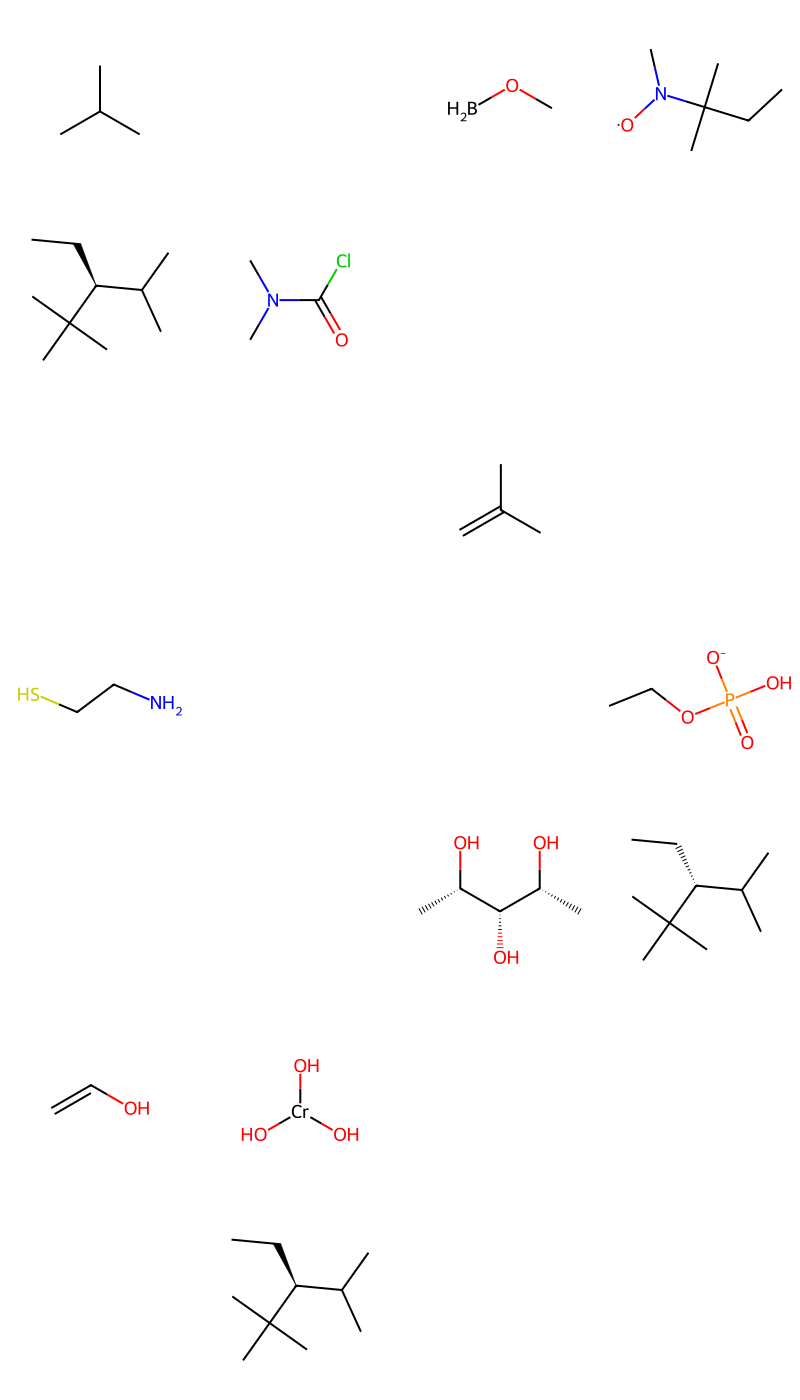

In [32]:
tox_frag_fp_574 = [Chem.MolFromSmiles(smi) for smi in list(all_train_fps[574])]

Draw.MolsToGridImage(mols=tox_frag_fp_574, molsPerRow=4)

[21:54:22] non-ring atom 0 marked aromatic
[21:54:22] non-ring atom 1 marked aromatic
[21:54:22] non-ring atom 0 marked aromatic
[21:54:22] non-ring atom 0 marked aromatic
[21:54:22] non-ring atom 0 marked aromatic
[21:54:22] non-ring atom 0 marked aromatic
[21:54:22] non-ring atom 0 marked aromatic
[21:54:22] non-ring atom 0 marked aromatic
[21:54:22] non-ring atom 0 marked aromatic
[21:54:22] non-ring atom 0 marked aromatic
[21:54:22] non-ring atom 0 marked aromatic


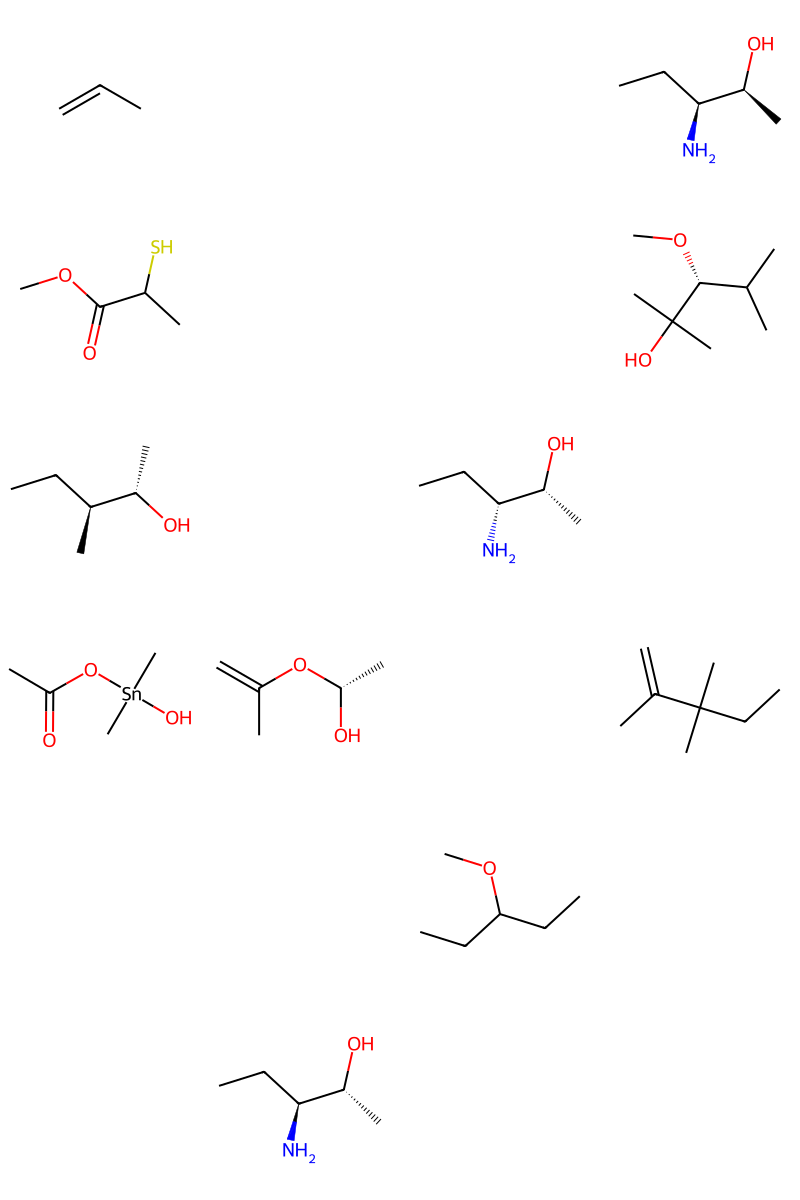

In [33]:
tox_frag_fp_84 = [Chem.MolFromSmiles(smi) for smi in list(all_train_fps[84])]

Draw.MolsToGridImage(mols=tox_frag_fp_84, molsPerRow=4)

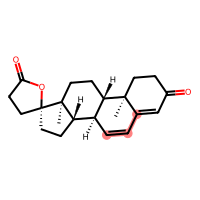

In [34]:
# Map the fragments that activate the fingerprints on selected molecule
mol_list = [Chem.MolFromSmiles(test_dataset.ids[tox_id])]
propylene = Chem.MolFromSmarts('C=CC')
match_list = [mol.GetSubstructMatches(propylene) for mol in mol_list]

(m1, m2, m3, m4, m5) = match_list[0]

Draw.MolsToGridImage(mols=mol_list, highlightAtomLists=[m1], molsPerRow=1)

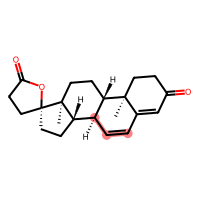

In [35]:
Draw.MolsToGridImage(mols=mol_list, highlightAtomLists=[m2], molsPerRow=1)

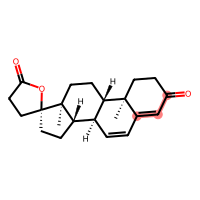

In [36]:
Draw.MolsToGridImage(mols=mol_list, highlightAtomLists=[m3], molsPerRow=1)

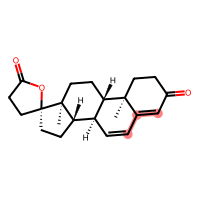

In [37]:
Draw.MolsToGridImage(mols=mol_list, highlightAtomLists=[m4], molsPerRow=1)

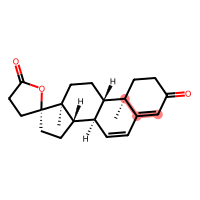

In [38]:
Draw.MolsToGridImage(mols=mol_list, highlightAtomLists=[m5], molsPerRow=1)

In [39]:
! pip install git+https://github.com/PatWalters/rd_filters.git

  Cloning https://github.com/PatWalters/rd_filters.git to /tmp/pip-req-build-hheqlqvq
  Running command git clone --filter=blob:none --quiet https://github.com/PatWalters/rd_filters.git /tmp/pip-req-build-hheqlqvq
  Resolved https://github.com/PatWalters/rd_filters.git to commit 3630f1a59150b4a203c2f06d8376a66d1d4c3f70
  Preparing metadata (setup.py) ... done


In [40]:
! rd_filters -h

Usage:
rd_filters filter --in INPUT_FILE --prefix PREFIX [--rules RULES_FILE_NAME] [--alerts ALERT_FILE_NAME][--np NUM_CORES]
rd_filters template --out TEMPLATE_FILE [--rules RULES_FILE_NAME]

Options:
--in INPUT_FILE input file name
--prefix PREFIX prefix for output file names
--rules RULES_FILE_NAME name of the rules JSON file
--alerts ALERTS_FILE_NAME name of the structural alerts file
--np NUM_CORES the number of cpu cores to use (default is all)
--out TEMPLATE_FILE parameter template file name


In [41]:
! echo 'C[C@]12CC[C@H]3[C@@H](C=CC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@@]21CCC(=O)O1 MOL0001' | tee smiles.smi

C[C@]12CC[C@H]3[C@@H](C=CC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@@]21CCC(=O)O1 MOL0001


In [42]:
!rd_filters filter --in smiles.smi --prefix out

using 8 cores
Using alerts from Inpharmatica
Wrote SMILES for molecules passing filters to out.smi
Wrote detailed data to out.csv
0 of 1 passed filters 0.0%
Elapsed time 0.06 seconds


In [43]:
rd_filters_df = pd.read_csv('out.csv')
rd_filters_df

,SMILES,NAME,FILTER,MW,LogP,HBD,HBA,TPSA,Rot
0,C[C@]12CC[C@H]3[C@@H](C=CC4=CC(=O)CC[C@@]43C)[...,MOL0001,Filter44_michael_acceptor2 > 0,340.463,4.3701,0,3,43.37,0


In [44]:
rd_filters_alerts_df = pd.read_csv('alert_collection.csv')
rd_filters_alerts_df.head()

,rule_id,rule_set,description,smarts,rule_set_name,priority,max
0,1,1,R1 Reactive alkyl halides,"[Br,Cl,I][CX4;CH,CH2]",Glaxo,8,0
1,2,1,R2 Acid halides,"[S,C](=[O,S])[F,Br,Cl,I]",Glaxo,8,0
2,3,1,R3 Carbazides,O=CN=[N+]=[N-],Glaxo,8,0
3,4,1,R4 Sulphate esters,"COS(=O)O[C,c]",Glaxo,8,0
4,5,1,R5 Sulphonates,"COS(=O)(=O)[C,c]",Glaxo,8,0


In [45]:
rd_filters_alerts_df[rd_filters_alerts_df['description'] == 'Filter44_michael_acceptor2']

,rule_id,rule_set,description,smarts,rule_set_name,priority,max
1146,1147,7,Filter44_michael_acceptor2,"[$([C!$(C1(=O)C=CC(=O)C=C1)]C),$([Ch]),$(C[OH0...",Inpharmatica,1,0


In [46]:
# smarts [$([C!$(C1(=O)C=CC(=O)C=C1)]C),$([Ch]),$(C[OH0])](=O)C=[C!$(C[Nv3X3,OH])]
smarts = rd_filters_alerts_df[rd_filters_alerts_df['description'] == 'Filter44_michael_acceptor2']['smarts']
smarts = smarts.iloc[0]

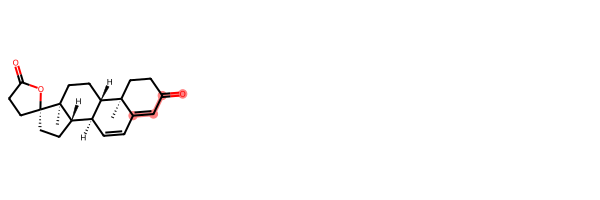

In [47]:
mol_list = [Chem.MolFromSmiles(test_dataset.ids[tox_id])]
michael_acceptor2 = Chem.MolFromSmarts(smarts)
match_list = [mol.GetSubstructMatch(michael_acceptor2) for mol in mol_list]

Draw.MolsToGridImage(mols=mol_list, highlightAtomLists=match_list, molsPerRow=3)